# Accessing the fly connectome dataset with CAVE

This notebook provides a high-level overview for how to access FlyWire's dataset through CAVE. CAVE is the [connectome annotation versioning engine](https://www.biorxiv.org/content/10.1101/2023.07.26.550598v1.abstract), a service infrastructure for managing connectomics datasets and is hosted in the cloud for broad access. CAVE supports proofreading of datasets and their analysis even while proofreading is ongoing.

The goal of this notebook is to query the Flywire dataset using CAVE client. We will start with brain wide queries to understand how neurons and stuctures are classified and annotated in this dataset and then take example of single neruons to understand if we can query connections that these single neurons makes with the wider brain data set.

# CAVEclient and setup

The CAVEclient is a python library that facilitates communication with a CAVE system. It can be install with

`pip install caveclient`

To install the caveclient when running this in a colab notebook, run:

In [1]:
!pip install caveclient
!pip install seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.6 MB/s eta 0:00:00


and imported like so:

In [2]:
import caveclient
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

## CAVE account setup

Each and every user needs to create a CAVE account and download a user token to access CAVE's services programmatically. FlyWire's data is publicly available which means that no extra permissions need to be given to a new user account to access the data.

A Google account (or Google-enabled account) is required to create a CAVE account.

#### Start here if you do not have a CAVE account or are not sure

Login to CAVE to setup a new account. To do this go to this [website](https://prod.flywire-daf.com/materialize/views/datastack/flywire_fafb_public).

#### Once you have an account: Setup your token

Create a new token by running the next cell. Then, copy the token and insert it into the argument of the following cell. These two cells should be redone together to make sure that the correct token is stored on your machine. You can copy your token and store on as many machines as you like. If you think your token has been compromised just reset it but rerunning the following cell.

In [3]:
client = caveclient.CAVEclient()
client.auth.setup_token(make_new=True)

New Tokens need to be acquired by hand. Please follow the following steps:
                1) Go to: https://global.daf-apis.com/auth/api/v1/create_token to create a new token.
                2) Log in with your Google credentials and copy the token shown afterward.
                3a) Save it to your computer with: client.auth.save_token(token="PASTE_YOUR_TOKEN_HERE")
                or
                3b) Set it for the current session only with client.auth.token = "PASTE_YOUR_TOKEN_HERE"
                Note: If you need to save or load multiple tokens, please read the documentation for details.
                Warning! Creating a new token by finishing step 2 will invalidate the previous token!


### Set or save your token

From the website that just opened up, paste your token here:

In [5]:
my_token = "7cb9fc1cc7b52149ecaa870c120b731f"

If you are running this on your local machine or on a server you can (optionally) store the token on your machine. This makes future uses easier.

In [6]:
# This might not work and that is okay
client.auth.save_token(token=my_token, overwrite=True)

## Initialize CAVEclient with a datastack

Datasets in CAVE are organized as datastacks. These are a combination of an EM dataset, a segmentation and a set of annotations. The datastack for FlyWire's public release is `flywire_fafb_public`. When you instantiate your client with this datastack, it loads all relevant information to access it.

In [7]:
datastack_name = "flywire_fafb_public"
client = caveclient.CAVEclient(datastack_name)

# One can pass the token directly to the client:
# client = caveclient.CAVEclient(datastack_name, auth_token=my_token)

## Materialization versions

Data in CAVE is timestamped and periodically versioned - each (materialization) version corresponds to a specific timestamp. Individual versions are made publicly available. The materialization service provides annotation queries to the dataset. It is available under `client.materialize`.

Currently the following versions are publicly available:

In [8]:
client.materialize.get_versions()

[630, 783]

And these are their associated timestamps (all timestamps are in UTC):

In [9]:
for version in client.materialize.get_versions():
    print(f"Version {version}: {client.materialize.get_timestamp(version)}")

Version 630: 2023-03-21 08:10:01.194185+00:00
Version 783: 2023-09-30 05:10:01.441140+00:00


The client will automatically query the latest materialization version. You can specify a `materialization_version` for every query if you want to access a specific version.

## **Student Task 1: Now we are going to systematically query this data set. Summarize what you have learnt about this data set so far. (2-3 bullet points are ok) **

# Querying the dataset

Let's have a look what annotation tables are available:

In [10]:
client.materialize.get_tables()

['hierarchical_neuron_annotations',
 'neuron_information_v2',
 'synapses_nt_v1',
 'nuclei_v1',
 'proofread_neurons',
 'fly_synapses_neuropil_v6']

## Querying neurons

The `proofread_neurons` table contains all neurons that were released in a given version. The dataset contains many more segments that were either not proofread because they are small, or belong to non-neuronal cells or other structures such as trachea. Therefore, knowing the list of all segments that represent proofread neurons is useful. It can be queried in full:

In [11]:
proofread_neurons_df = client.materialize.query_table("proofread_neurons")
proofread_neurons_df

,id,created,superceded_id,valid,pt_supervoxel_id,pt_root_id,pt_position
0,32414,2023-06-19 06:44:57.863498+00:00,<NA>,True,79871411195357919,720575940620919646,"[538210, 198330, 105601]"
1,1125,2023-06-19 06:43:33.633089+00:00,<NA>,True,77195887289571552,720575940611775973,"[381459, 106763, 171723]"
2,32416,2023-06-19 06:44:57.865882+00:00,<NA>,True,78955586729523534,720575940618135198,"[486480, 133840, 123110]"
3,32418,2023-06-19 06:44:57.867936+00:00,<NA>,True,79589661206805006,720575940624783287,"[523906, 181893, 72760]"
4,32419,2023-06-19 06:44:57.869497+00:00,<NA>,True,79589661207074646,720575940630755276,"[523523, 181919, 80829]"
...,...,...,...,...,...,...,...
139250,104828,2023-06-19 06:48:15.001237+00:00,<NA>,True,83952592400822837,720575940626100238,"[776911, 183792, 174548]"
139251,104809,2023-06-19 06:48:14.983796+00:00,<NA>,True,84798048190170122,720575940626915216,"[824625, 246096, 194229]"
139252,83362,2023-06-19 06:47:20.709997+00:00,<NA>,True,75298954786869572,720575940645731620,"[272447, 288010, 156593]"
139253,104819,2023-06-19 06:48:14.992064+00:00,<NA>,True,84658822530652061,720575940629075755,"[815896, 335911, 204215]"


# **Student Task 2: How many rows and columns do you see? Based on discussion in class so far what do you think proofreading entails and why is it necessary?**

In the table above each row is a proofread neuron. Segment IDs (aka neuron IDs) are called `root_ids` in CAVE. Each annotation is associated with at least one point with which data is associated; in this case `pt_root_id` and `pt_position` are the most relevant columns.

Positions in this table were calculated to be in the backbone of a neuron. This was found to be the most robust location to identify a neuron with as some do not have cell bodies and cell bodies are not central to fly neurons. There is a table that represents all _cell_ nuclei in the brain created by [Shang et al.](https://www.biorxiv.org/content/10.1101/2021.11.04.467197v1.abstract)

# **Student Task 3: How many rows and columns do you see? Discuss with your partner what supervoxel id, root id and pt position mean.**

In [ ]:
nuclei_df = client.materialize.query_table("nuclei_v1")
nuclei_df

,id,created,superceded_id,valid,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,7393349,2021-06-23 19:55:35.159040+00:00,<NA>,True,26.141245,82827379285852979,720575940626838909,"[709888, 227744, 57160]","[708032, 226144, 54760]","[711904, 229440, 59280]"
1,7416439,2021-06-23 19:55:35.160196+00:00,<NA>,True,11.523399,82827998029690530,720575940620043899,"[710592, 263392, 129800]","[708800, 262112, 128200]","[712064, 264832, 131080]"
2,7415038,2021-06-23 19:55:35.161401+00:00,<NA>,True,32.895958,83038623024880664,720575940626046919,"[722528, 234656, 77000]","[720768, 232896, 74480]","[724224, 236576, 79360]"
3,7415013,2021-06-23 19:55:35.162579+00:00,<NA>,True,53.711174,83038760463398837,720575940630311383,"[722912, 244032, 65200]","[720480, 242144, 62480]","[725600, 246208, 67760]"
4,7415848,2021-06-23 19:55:35.164060+00:00,<NA>,True,9.280717,83038554439606237,720575940633370649,"[721984, 229792, 119560]","[720832, 228320, 118240]","[723232, 231264, 120840]"
...,...,...,...,...,...,...,...,...,...,...
143135,4389032,2021-06-23 20:02:31.089586+00:00,<NA>,True,244.330338,79377386675948158,720575940629762043,"[511328, 113024, 48560]","[503744, 104128, 44600]","[520704, 122080, 53040]"
143136,8558952,2021-06-23 20:02:31.090874+00:00,<NA>,True,253.35939,84870066067479558,720575940621362085,"[830720, 344608, 149840]","[821120, 335680, 146960]","[840576, 354912, 152880]"
143137,3076633,2021-06-23 20:02:31.092008+00:00,<NA>,True,261.782532,78042030341189115,720575940650929273,"[433152, 210560, 223440]","[428544, 206976, 219120]","[437632, 214048, 227600]"
143138,3125634,2021-06-23 20:02:31.093103+00:00,<NA>,True,274.994598,78113635431454405,720575940621426568,"[434208, 282112, 23400]","[429728, 278496, 19040]","[439264, 285568, 27320]"


Not all neurons contains have a cell body in the brain (e.g. sensory, ascending) and for ~6,000 of intrinsic neurons, the segmentation did not reach up to the cell bodies which are sitting at the outer layer of the brain. In those cases, the `pt_root_id` is 0. This table also contains glia cell bodies, as well as a few false positive annotations.

Every table has an associated description which provides further context and references to publications. This feature is provided by the annotation service which can be reached at `cave.annotation`.

# **Student Task 4: How many rows and columns do you see? Are the number of rows longer or shorter than proofread neurons. If there is a difference why do you think that is the case.**

In [ ]:
print(client.annotation.get_table_metadata("nuclei_v1")["description"])


FlyWire nucleus description
Nucleus version: 20210322

Nuclei in this table consist of center points (in nm), volume (in μm3), and bounding boxes (in nm).

The nucleus segmentation was generated by Shang Mu (smu@princeton.edu, Seung Lab at Princeton University) using a 2D convolutional neural network (CNN) and heuristic interpolations. The training data was assembled from annotations by Selden Koolman, Merlin Moore, Sarah Morejohn, Ben Silverman, Kyle Willie, Ryan Willie, Szi-chieh Yu and Shang Mu.

As this data was generated using a 2D, rather than 3D, neural network, defects are present in the detected nuclei, particularly where there are large defects in section alignment or a number of consecutive missing sections.

False positive fragments, nucleus fragments and partial nuclei are the most common type of defects. A simple, rudimentary method for cleaning up is to disregard small fragments by thresholding by segment size or by the z-dimension of the bounding boxes. A size threshol

Positions can be useful for analysis. The CAVEclient provides some convenience functions:

Splitting of position columns into separate x, y, and z columns

In [ ]:
nuclei_df = client.materialize.query_table("nuclei_v1", split_positions=True)
nuclei_df

,id,created,superceded_id,valid,volume,pt_position_x,pt_position_y,pt_position_z,bb_start_position_x,bb_start_position_y,bb_start_position_z,bb_end_position_x,bb_end_position_y,bb_end_position_z,pt_supervoxel_id,pt_root_id
0,7393349,2021-06-23 19:55:35.159040+00:00,<NA>,True,26.141245,709888,227744,57160,708032,226144,54760,711904,229440,59280,82827379285852979,720575940626838909
1,7416439,2021-06-23 19:55:35.160196+00:00,<NA>,True,11.523399,710592,263392,129800,708800,262112,128200,712064,264832,131080,82827998029690530,720575940620043899
2,7415038,2021-06-23 19:55:35.161401+00:00,<NA>,True,32.895958,722528,234656,77000,720768,232896,74480,724224,236576,79360,83038623024880664,720575940626046919
3,7415013,2021-06-23 19:55:35.162579+00:00,<NA>,True,53.711174,722912,244032,65200,720480,242144,62480,725600,246208,67760,83038760463398837,720575940630311383
4,7415848,2021-06-23 19:55:35.164060+00:00,<NA>,True,9.280717,721984,229792,119560,720832,228320,118240,723232,231264,120840,83038554439606237,720575940633370649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143135,4389032,2021-06-23 20:02:31.089586+00:00,<NA>,True,244.330338,511328,113024,48560,503744,104128,44600,520704,122080,53040,79377386675948158,720575940629762043
143136,8558952,2021-06-23 20:02:31.090874+00:00,<NA>,True,253.35939,830720,344608,149840,821120,335680,146960,840576,354912,152880,84870066067479558,720575940621362085
143137,3076633,2021-06-23 20:02:31.092008+00:00,<NA>,True,261.782532,433152,210560,223440,428544,206976,219120,437632,214048,227600,78042030341189115,720575940650929273
143138,3125634,2021-06-23 20:02:31.093103+00:00,<NA>,True,274.994598,434208,282112,23400,429728,278496,19040,439264,285568,27320,78113635431454405,720575940621426568


Defining the position resolution. Resolutions are always in nanometers and this query asks for points to be provided in micrometers (aka 1000 nanometers):

## Querying annotations - hierarchical annotations from Schlegel et al., 2023

[Schlegel et al](https://www.biorxiv.org/content/10.1101/2023.06.27.546055v2.abstract) introduced hierarchical annotations for all proofread neurons in the dataset. Figure 1 from their paper (shown below) outlines the hierarchy and renders individual groups of neuurons.



![](https://www.biorxiv.org/content/biorxiv/early/2023/07/15/2023.06.27.546055/F1.large.jpg)

To load all annotations (this will take ~20s):

In [ ]:
hierarchical_annos_df = client.materialize.query_table("hierarchical_neuron_annotations", limit=10)
hierarchical_annos_df

,id_ref,created_ref,valid_ref,pt_supervoxel_id,pt_root_id,id,created,valid,target_id,classification_system,cell_type,pt_position
0,1,2023-06-19 06:43:32.562416+00:00,True,78253067652813181,720575940628857210,601615,2023-06-19 23:31:33.449997+00:00,True,1,super_class,central,"[443342, 203965, 157450]"
1,1,2023-06-19 06:43:32.562416+00:00,True,78253067652813181,720575940628857210,473637,2023-06-19 23:26:01.973320+00:00,True,1,flow,intrinsic,"[443342, 203965, 157450]"
2,2,2023-06-19 06:43:32.563301+00:00,True,82053323167374089,720575940626838909,879934,2023-09-30 05:09:51.441140+00:00,True,2,cell_type,CB0924,"[664417, 227538, 77011]"
3,2,2023-06-19 06:43:32.563301+00:00,True,82053323167374089,720575940626838909,601616,2023-06-19 23:31:33.451271+00:00,True,2,super_class,central,"[664417, 227538, 77011]"
4,2,2023-06-19 06:43:32.563301+00:00,True,82053323167374089,720575940626838909,473638,2023-06-19 23:26:01.974049+00:00,True,2,flow,intrinsic,"[664417, 227538, 77011]"
5,3,2023-06-19 06:43:32.564159+00:00,True,81842766824648491,720575940626046919,601617,2023-06-19 23:31:33.452516+00:00,True,3,super_class,central,"[653666, 259618, 110467]"
6,3,2023-06-19 06:43:32.564159+00:00,True,81842766824648491,720575940626046919,473639,2023-06-19 23:26:01.974760+00:00,True,3,flow,intrinsic,"[653666, 259618, 110467]"
7,4,2023-06-19 06:43:32.565063+00:00,True,82405647924682371,720575940630311383,601618,2023-06-19 23:31:33.453745+00:00,True,4,super_class,central,"[687457, 254763, 80194]"
8,4,2023-06-19 06:43:32.565063+00:00,True,82405647924682371,720575940630311383,473640,2023-06-19 23:26:01.975449+00:00,True,4,flow,intrinsic,"[687457, 254763, 80194]"
9,5,2023-06-19 06:43:32.566002+00:00,True,82756942157675987,720575940633370649,601619,2023-06-19 23:31:33.455445+00:00,True,5,super_class,visual_projection,"[707653, 222503, 145366]"


The `classification_system` column encodes the level of the hierarchy a given annotation belongs to. Only annotations for `flow` and `super class` are available for all neurons but finer annotations are only available for subsets of neurons. We can see that in the annotation counts for each hierarchy level:

# **Student task 5: Discuss with your partner why each level of heirarchial annotations is critical and one insight you can get from each level (flow, superclass, class and cell type).**

Next we will drill down these table and get lists for individual classifications.

## Subqueries - hierarchical annotations from Schlegel et al., 2023 continued

CAVE poses a limit on the size of a table that can be loaded at once. The current limit is `500,000` rows. This is to ensure the system is working for everyone and prevents accidentaly large queries to the server - that is particularly relevant for synapse queries.

The hierarchical annotation table is too large to be loaded as a whole. To load a subset of the data, we can use a filter on any column to reduce the data footprint:


In [ ]:
flow_annos_df = client.materialize.query_table("hierarchical_neuron_annotations", filter_equal_dict={"classification_system": "flow"})
flow_annos_df

,id_ref,created_ref,valid_ref,pt_supervoxel_id,pt_root_id,id,created,valid,target_id,classification_system,cell_type,pt_position
0,135,2023-06-19 06:43:32.694340+00:00,True,78536398189730110,720575940628372613,760326,2023-09-30 05:09:51.441140+00:00,True,135,flow,efferent,"[462134, 314944, 202595]"
1,131206,2024-01-08 19:46:33.536372+00:00,True,79097217839414238,720575940620156283,760327,2023-09-30 05:09:51.441140+00:00,True,131206,flow,efferent,"[492890, 187909, 204117]"
2,138571,2024-01-08 19:46:56.609400+00:00,True,81277136946061019,720575940640372277,760328,2023-09-30 05:09:51.441140+00:00,True,138571,flow,intrinsic,"[620140, 99296, 158026]"
3,137463,2024-01-08 19:46:56.002999+00:00,True,80434498856324372,720575940634601954,760329,2023-09-30 05:09:51.441140+00:00,True,137463,flow,intrinsic,"[570818, 205376, 191260]"
4,133024,2024-01-08 19:46:44.939864+00:00,True,81840568002630413,720575940624155416,760330,2023-09-30 05:09:51.441140+00:00,True,133024,flow,intrinsic,"[652270, 128644, 169218]"
...,...,...,...,...,...,...,...,...,...,...,...,...
139250,104828,2023-06-19 06:48:15.001237+00:00,True,83952592400822837,720575940626100238,397994,2023-06-19 23:22:47.293270+00:00,True,104828,flow,intrinsic,"[776911, 183792, 174548]"
139251,104809,2023-06-19 06:48:14.983796+00:00,True,84798048190170122,720575940626915216,436766,2023-06-19 23:24:21.179830+00:00,True,104809,flow,intrinsic,"[824625, 246096, 194229]"
139252,83362,2023-06-19 06:47:20.709997+00:00,True,75298954786869572,720575940645731620,402701,2023-06-19 23:23:00.124836+00:00,True,83362,flow,intrinsic,"[272447, 288010, 156593]"
139253,104819,2023-06-19 06:48:14.992064+00:00,True,84658822530652061,720575940629075755,436758,2023-06-19 23:24:21.174050+00:00,True,104819,flow,intrinsic,"[815896, 335911, 204215]"


Besides `filter_equal_dict`, the CAVEclient provides `filter_in_dict` and `filter_out_dict` as options to restrict what data is loaded.

# **Student task 6: Work with a partner to discuss what flow means? Why is flow critical in understanding function? What do the words afferent, efferent and intrinsic mean. Find a root id of each type?**


Examples:

In [ ]:
cell_class_type_annos_df = client.materialize.query_table("hierarchical_neuron_annotations", filter_in_dict={"classification_system": ["cell_class", "cell_type"]})
cell_class_type_annos_df

,id_ref,created_ref,valid_ref,pt_supervoxel_id,pt_root_id,id,created,valid,target_id,classification_system,cell_type,pt_position
0,30,2023-06-19 06:43:32.592246+00:00,True,79588355603633144,720575940614623455,784021,2023-09-30 05:09:51.441140+00:00,True,30,cell_class,pars_intercerebralis,"[521186, 102405, 87485]"
1,32,2023-06-19 06:43:32.594078+00:00,True,79588286884639566,720575940603765280,784022,2023-09-30 05:09:51.441140+00:00,True,32,cell_class,pars_intercerebralis,"[522523, 97588, 102599]"
2,106,2023-06-19 06:43:32.670532+00:00,True,79519361115064925,720575940616153371,784023,2023-09-30 05:09:51.441140+00:00,True,106,cell_class,pars_intercerebralis,"[518966, 183364, 54017]"
3,322,2023-06-19 06:43:32.918061+00:00,True,79309629405975492,720575940632879842,784024,2023-09-30 05:09:51.441140+00:00,True,322,cell_class,TPN,"[503664, 265302, 85460]"
4,116554,2023-06-19 06:48:44.982060+00:00,True,80574205418215064,720575940620926740,784025,2023-09-30 05:09:51.441140+00:00,True,116554,cell_class,pars_lateralis,"[578618, 142964, 148739]"
...,...,...,...,...,...,...,...,...,...,...,...,...
216657,83345,2023-06-19 06:47:20.696479+00:00,True,76071499211627283,720575940632125521,753717,2023-06-22 03:47:42.513711+00:00,True,83345,cell_type,T4a,"[316848, 199076, 184279]"
216658,83374,2023-06-19 06:47:20.719586+00:00,True,76071705369927669,720575940619054238,753718,2023-06-22 03:47:42.514694+00:00,True,83374,cell_type,T4a,"[317912, 208064, 180147]"
216659,104840,2023-06-19 06:48:15.014430+00:00,True,74595267680358869,720575940632299538,754848,2023-06-22 03:47:43.418885+00:00,True,104840,cell_type,Mi1,"[232864, 289213, 251319]"
216660,83326,2023-06-19 06:47:20.681260+00:00,True,84658616439355465,720575940623458428,753716,2023-06-22 03:47:42.513040+00:00,True,83326,cell_type,Mi1,"[818664, 323279, 224861]"


# Student Task 7: What is the difference between the flow table and the cell_class_type table?
# Can you create a code block to query a table for just cell type using filter_in_dict? A lot of this is copying and pasting code

In [ ]:
cell_type_annos_df = client.materialize.query_table("hierarchical_neuron_annotations", filter_in_dict={"classification_system": ["cell_type"]})
cell_type_annos_df

,id_ref,created_ref,valid_ref,pt_supervoxel_id,pt_root_id,id,created,valid,target_id,classification_system,cell_type,pt_position
0,32414,2023-06-19 06:44:57.863498+00:00,True,79871411195357919,720575940620919646,894146,2023-09-30 05:09:51.441140+00:00,True,32414,cell_type,CB.FB2K1,"[538210, 198330, 105601]"
1,1125,2023-06-19 06:43:33.633089+00:00,True,77195887289571552,720575940611775973,880423,2023-09-30 05:09:51.441140+00:00,True,1125,cell_type,CB1188,"[381459, 106763, 171723]"
2,32421,2023-06-19 06:44:57.872169+00:00,True,79873472712634790,720575940607253170,894149,2023-09-30 05:09:51.441140+00:00,True,32421,cell_type,CB0011,"[540013, 321320, 87831]"
3,32423,2023-06-19 06:44:57.874747+00:00,True,82616410559741731,720575940617224093,894150,2023-09-30 05:09:51.441140+00:00,True,32423,cell_type,CB1211,"[698725, 233422, 77117]"
4,32425,2023-06-19 06:44:57.877806+00:00,True,81911349130846298,720575940625290003,746708,2023-06-22 03:47:24.549746+00:00,True,32425,cell_type,KCab,"[655290, 153943, 192032]"
...,...,...,...,...,...,...,...,...,...,...,...,...
109253,104828,2023-06-19 06:48:15.001237+00:00,True,83952592400822837,720575940626100238,754847,2023-06-22 03:47:43.418214+00:00,True,104828,cell_type,Mi1,"[776911, 183792, 174548]"
109254,104809,2023-06-19 06:48:14.983796+00:00,True,84798048190170122,720575940626915216,950685,2023-09-30 05:09:51.441140+00:00,True,104809,cell_type,TmY3,"[824625, 246096, 194229]"
109255,83362,2023-06-19 06:47:20.709997+00:00,True,75298954786869572,720575940645731620,930421,2023-09-30 05:09:51.441140+00:00,True,83362,cell_type,TmY4,"[272447, 288010, 156593]"
109256,104819,2023-06-19 06:48:14.992064+00:00,True,84658822530652061,720575940629075755,950693,2023-09-30 05:09:51.441140+00:00,True,104819,cell_type,TmY11,"[815896, 335911, 204215]"


Lets plot these data to get a sense for what we have. Lets start with flow.

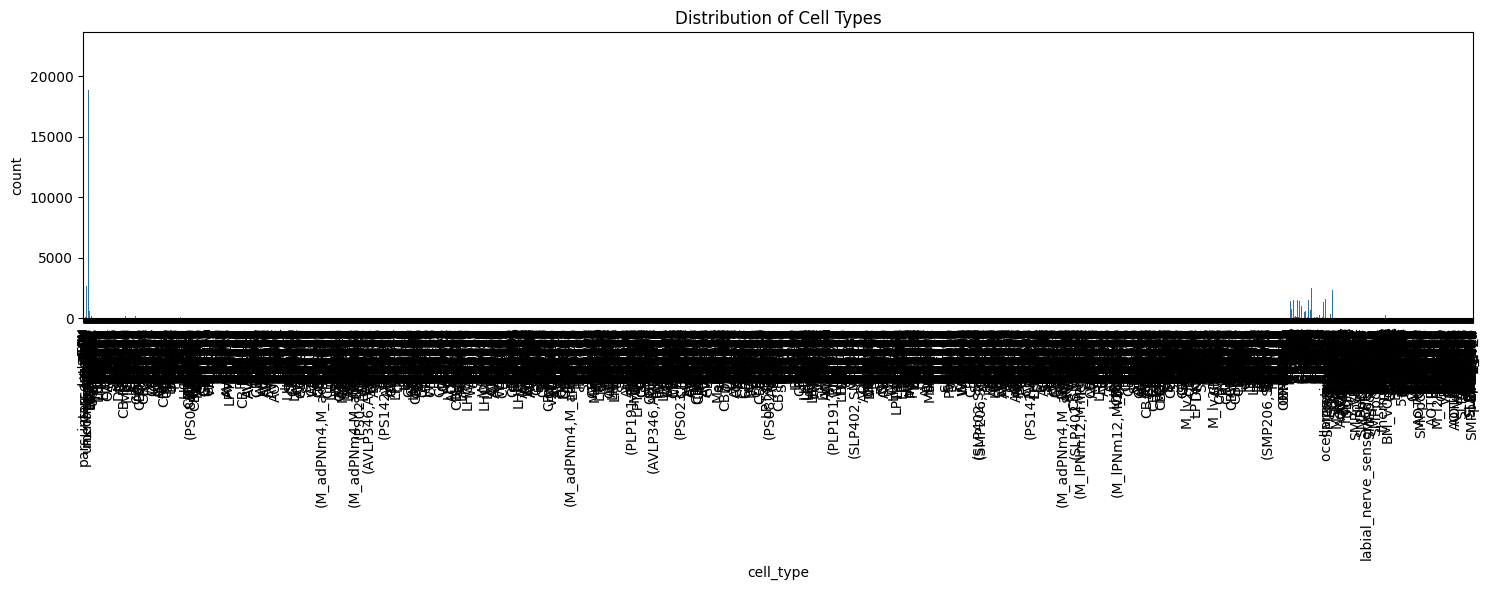

In [ ]:
plt.figure(figsize=(15, 6))
sns.countplot(data=cell_class_type_annos_df, x="cell_type")
plt.xticks(rotation=90)
plt.title("Distribution of Cell Types")
plt.tight_layout()
plt.show()


Did you get a messy graph, clean graph or no graph?

Student task: Copy and paste the graphing code from above and generate plots for  flow_annos_df



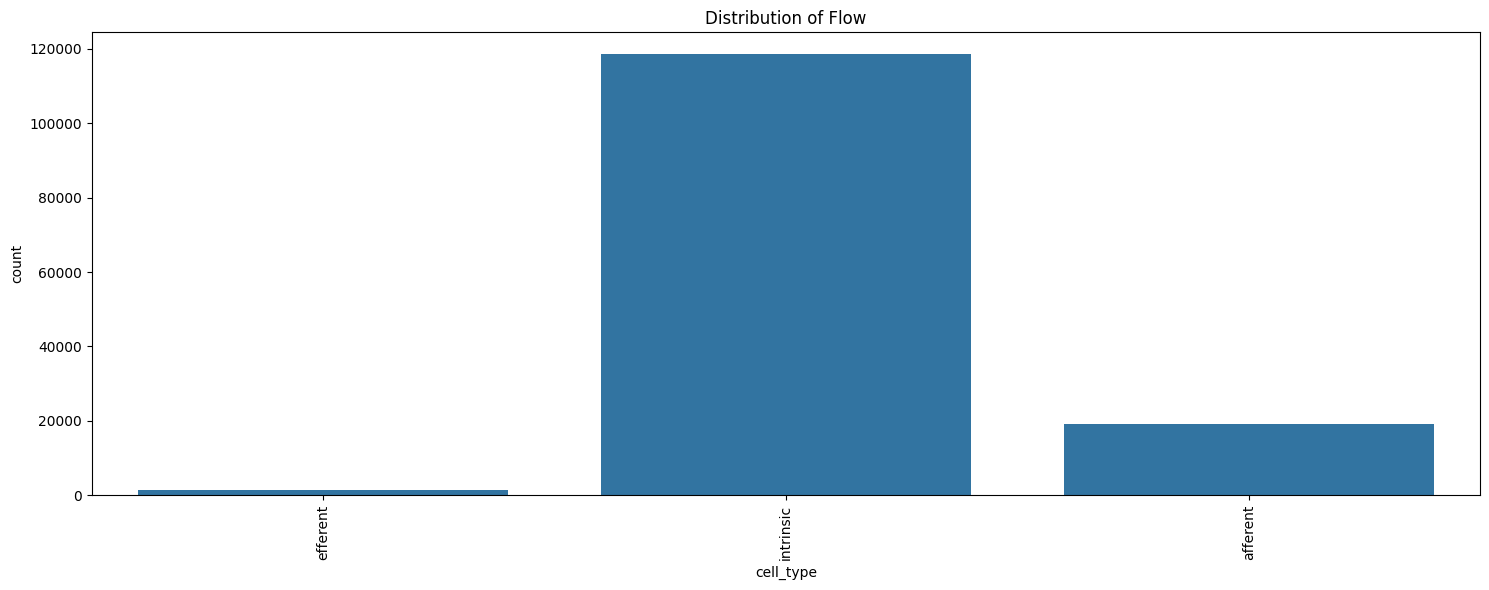

In [ ]:
plt.figure(figsize=(15, 6))
sns.countplot(data=flow_annos_df, x="cell_type")
plt.xticks(rotation=90)
plt.title("Distribution of Flow")
plt.tight_layout()
plt.show()

## Community annotations

The FlyWire community created additional annotations for ~85k cells in the dataset by the time of publication. These are free-form annotation tags that can be used for exploration and are not following any nomenclature.

Open science means that many people can be involved in the scientific process and community tags allow more collaboration and open sharing of data and ideas.

In [ ]:
community_anno_df = client.materialize.query_table("neuron_information_v2")

In [ ]:
community_anno_df

,id,created,superceded_id,valid,tag,user_id,pt_supervoxel_id,pt_root_id,pt_position
0,1,2022-02-07 04:55:09.705964+00:00,<NA>,True,putative fru,22,76774705348089545,720575940620306785,"[356596, 169884, 102760]"
1,2,2022-02-07 04:55:09.709199+00:00,<NA>,True,putative fru,2356,76774705348089545,720575940620306785,"[356596, 169884, 102760]"
2,3,2022-02-07 04:55:09.711648+00:00,<NA>,True,aIP1c,22,76774705348089545,720575940620306785,"[356596, 169884, 102760]"
3,4,2022-02-07 04:55:09.714147+00:00,<NA>,True,aIP1c,2356,76774705348089545,720575940620306785,"[356596, 169884, 102760]"
4,5,2022-02-07 04:55:09.716362+00:00,<NA>,True,putative fru,22,77197123904568079,720575940607848203,"[381456, 181024, 80800]"
...,...,...,...,...,...,...,...,...,...
156154,158470,2023-09-29 18:34:01.919332+00:00,<NA>,True,protocerebral interneuron Delta7; PB interneur...,392,81278923786668088,720575940628493828,"[620616, 204680, 197880]"
156155,158471,2023-09-29 22:29:22.074318+00:00,<NA>,True,Putative Translobula-plate 1; Tlp1 (with LOP a...,8,82546385882696610,720575940611942130,"[695628, 255712, 219440]"
156156,158472,2023-09-30 00:20:57.515962+00:00,<NA>,True,Retinula axon; R7,96,84165210193334222,720575940630042011,"[788080, 276144, 101680]"
156157,158473,2023-09-30 00:24:42.774939+00:00,<NA>,True,Retinula axon; R7,96,83602741276248008,720575940632709945,"[754976, 302952, 90120]"


Lets get connecting!!!

## Synapse queries

### Details about FlyWire's synapses

FlyWire uses automatically annotated synapses that were produced by [Buhmann et al.](https://www.nature.com/articles/s41592-021-01183-7). Automation of synapse annotation is critical for circuit analysis but one should keep in mind that the classifier may contain biases that lead to better or worse results in different brain regions. For instance, this classifier was trained on data acquired from neuropils in the central brain and might perform worse in the optic lobe or for sensory neurons. In total, Buhmann et al. identified ~244 million _putative_ synapses.

### Details about removal of false positive synapses

Each synapse is a link from a pre- to a posynaptic site. As presynapses in the fly are usually polysynaptic, there are usually multiple synapses for each presynaptic site. They assigned a `connection_score` to every synapse which can be used to filter out false positives. Buhmann et al. suggest to correlate their predictions with those from [Heinrich et al.](https://link.springer.com/chapter/10.1007/978-3-030-00934-2_36) who segmented synaptic cleft on the same dataset. This is implemented through a `cleft_score` that is associated with each synapse. We found that filtering synapses with a `cleft_score > 50` works well for removing false positives without using the `connection_score`.

Additionally, some synapses were annotated multiple times. We implemented a distance based filtering to remove redundant synapses.

## Synapse assignment to neuropils

We assigned every synapse to a neuropil based on its presynaptic location. Synapses that were outside a neuropil were assigned to the closest neuropil if that was within 10 µm.

### TLDR: Give me the data!

We created a filtered view of the synapse table that automatically applies all established filters to remove as many false positive synapses as possible. It also adds neuropil information. The view published with version 630 is `valid_synapses_nt_np`. For version 783 and later, we created `valid_synapses_nt_np_v6`, an updated version which only has minor differences to the previous version (`valid_synapses_nt_np` will remain functional for consistency). The main differences are that neuropil assignments in the optic lobes were improved.

For technical reasons, a different function has to be called to query this view:

In [12]:
client.materialize.query_view("valid_synapses_nt_np_v6", limit=10)

,id,pre_pt_root_id,post_pt_root_id,connection_score,cleft_score,gaba,ach,glut,oct,ser,da,valid_nt,pre_pt_supervoxel_id,post_pt_supervoxel_id,neuropil,pre_pt_position,post_pt_position
0,6,720575940630786105,720575940610739662,389.255432,79.0,0.01138,0.786194,0.003691,0.004627,0.001929,0.192179,True,76916748439646533,76916748439640439,AVLP_L,"[366592, 246144, 74360]","[366584, 246216, 74320]"
1,11,720575940630786105,720575940545913232,469.296295,147.0,0.004232,0.967565,0.000087,0.000342,0.000182,0.027592,True,76916748439639250,76916748439645298,AVLP_L,"[366560, 246144, 74440]","[366508, 246232, 74440]"
2,14,720575940630786105,720575940545912208,431.531738,130.0,0.000786,0.993792,0.000002,0.000006,0.000004,0.005412,True,76916748439651358,76916748439646534,AVLP_L,"[366428, 246060, 74560]","[366356, 246136, 74520]"
3,15,720575940630906435,720575940627911895,475.069672,140.0,0.376253,0.278226,0.332757,0.001309,0.000762,0.010693,True,76916748439657631,76916748439647565,AVLP_L,"[365584, 245064, 74680]","[365672, 245036, 74640]"
4,16,720575940630906435,720575940545916816,407.200562,151.0,0.341289,0.149622,0.499909,0.001995,0.001269,0.005916,True,76916748439651251,76916748439648883,AVLP_L,"[365624, 245136, 74680]","[365712, 245200, 74720]"
5,18,720575940630786105,720575940545920912,217.466217,122.0,0.007093,0.939359,0.00113,0.000747,0.000196,0.051474,True,76916748439663007,76916748439651348,AVLP_L,"[366252, 245948, 74640]","[366168, 245976, 74640]"
6,21,720575940630786105,720575940624184764,56.978813,146.0,0.006275,0.971317,0.000977,0.000983,0.000085,0.020363,True,76916748439651358,76916748439650144,AVLP_L,"[366232, 246012, 74680]","[366136, 246084, 74640]"
7,22,720575940630906435,720575940545901968,478.272552,146.0,0.334301,0.341355,0.311997,0.007425,0.000349,0.004572,True,76916748439651251,76916748439653785,AVLP_L,"[365624, 245112, 74720]","[365732, 245096, 74720]"
8,26,720575940619149904,720575940627911895,58.005123,145.0,0.310759,0.131895,0.522028,0.017178,0.004899,0.013241,True,76916748439651360,76916748439648983,AVLP_L,"[365704, 246068, 74720]","[365656, 245948, 74720]"
9,27,720575940619149904,720575940545911952,17.30275,143.0,0.262804,0.049032,0.643314,0.018544,0.008741,0.017565,True,76916748439651360,76916748439651344,AVLP_L,"[365756, 246080, 74720]","[365800, 245980, 74720]"


This query limits the query to 10 randomly chosen rows. The maximum per query is 500,000. There are approximately 110 million synapses available in this view. Queries need to be resticted to a given set of neurons.

### Querying synapses for specific neurons

Let's query synapses for a neuron OA-VPM3:
We need to first find it root id. Lets do this on codex.

In [13]:
root_id = 720575940640356149

VPM3_presyn_df = client.materialize.query_view("valid_synapses_nt_np_v6", filter_in_dict={"pre_pt_root_id": [root_id]})
VPM3_postsyn_df = client.materialize.query_view("valid_synapses_nt_np_v6", filter_in_dict={"post_pt_root_id": [root_id]})

VPM3_postsyn: here means list of neurons where VPM3 is post-synaptic

VPM3_presyn: here means list of neurons where VPM3 is pre-synaptic

Good thing is that you can check this if you get confused like I do!!!!

In [14]:
VPM3_presyn_df



,id,pre_pt_root_id,post_pt_root_id,connection_score,cleft_score,gaba,ach,glut,oct,ser,da,valid_nt,pre_pt_supervoxel_id,post_pt_supervoxel_id,neuropil,pre_pt_position,post_pt_position
0,1104844,720575940640356149,720575940638662352,221.199539,111.0,0.00005,0.0,0.000001,0.991486,0.000575,0.007888,True,81347780299512285,81347711579877970,MB_VL_R,"[624512, 113208, 74120]","[624492, 113072, 74120]"
1,154070891,720575940640356149,720575940622212615,71.059418,119.0,0.000057,0.000003,0.00004,0.882026,0.099249,0.018625,True,81911211356506174,81911211356519668,SLP_R,"[657424, 142796, 94760]","[657460, 142692, 94720]"
2,124999815,720575940640356149,720575940610278526,66.838005,160.0,0.07405,0.02451,0.852963,0.01321,0.005852,0.029415,True,81489273769066533,81489273769066514,SIP_R,"[630536, 160348, 85560]","[630480, 160196, 85520]"
3,90426220,720575940640356149,720575940654241441,269.171753,142.0,0.000568,0.000121,0.00067,0.527657,0.347476,0.123507,True,81488724147501528,81488724147498533,SLP_R,"[631272, 125892, 127520]","[631184, 125816, 127520]"
4,67800259,720575940640356149,720575940615183071,292.163239,137.0,0.0,0.0,0.0,1.0,0.0,0.0,True,81419042799393449,81419042799399383,MB_CA_R,"[627668, 166764, 188040]","[627544, 166688, 188040]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3090,146754373,720575940640356149,720575940589154959,346.663361,126.0,0.0,0.0,0.0,0.999999,0.000001,0.0,True,80363786246595958,80363786246575083,FB,"[568636, 185692, 118040]","[568692, 185628, 118000]"
3091,40081391,720575940640356149,720575940530898883,194.129333,144.0,0.00929,0.04775,0.940199,0.000002,0.002617,0.000143,True,80363648874444272,80363648874442894,FB,"[568172, 176680, 129560]","[568132, 176552, 129560]"
3092,120300417,720575940640356149,720575940618734575,319.7258,52.0,0.000025,0.0,0.000025,0.997971,0.000554,0.001424,True,80293417435453244,80293417435457124,FB,"[564080, 184632, 102240]","[564048, 184472, 102240]"
3093,219038500,720575940640356149,720575940624730638,77.560898,150.0,0.0,0.0,0.0,1.0,0.0,0.0,True,80293280063539907,80293280063535989,FB,"[562596, 176656, 121120]","[562720, 176668, 121120]"


In [15]:
VPM3_postsyn_df

,id,pre_pt_root_id,post_pt_root_id,connection_score,cleft_score,gaba,ach,glut,oct,ser,da,valid_nt,pre_pt_supervoxel_id,post_pt_supervoxel_id,neuropil,pre_pt_position,post_pt_position
0,75113388,720575940614515398,720575940640356149,226.538925,97.0,0.000896,0.997696,0.000018,0.0,0.000303,0.001087,True,79659480396210436,79659480396210442,FB,"[527620, 149752, 125840]","[527536, 149804, 125800]"
1,181816631,720575940626283838,720575940640356149,174.600281,140.0,0.000234,0.996293,0.0,0.000005,0.000027,0.003441,True,77196093246764395,77196093246760820,SLP_L,"[381464, 117432, 112600]","[381536, 117476, 112640]"
2,98874968,720575940614927646,720575940640356149,151.906967,63.0,0.0,0.0,0.0,0.945973,0.000094,0.053933,True,81418423988587445,81418423988585998,SIP_R,"[630108, 132456, 86680]","[630160, 132392, 86720]"
3,34828525,720575940623855117,720575940640356149,141.549393,67.0,0.0,0.0,1.0,0.0,0.0,0.0,True,79096736601504099,79096736601522172,FB,"[492704, 161144, 135240]","[492740, 161252, 135240]"
4,226824993,720575940633926295,720575940640356149,46.45673,163.0,0.001946,0.951449,0.000313,0.012849,0.000134,0.033309,True,82192549028492000,82192549028497387,SLP_R,"[674456, 133964, 136440]","[674532, 133924, 136360]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,133576757,720575940608140380,720575940640356149,11.486587,131.0,0.000172,0.000019,0.001126,0.000956,0.646484,0.351244,True,80152748733076837,80152748733083674,FB,"[556624, 187884, 104720]","[556536, 187948, 104760]"
2021,222013885,720575940623428234,720575940640356149,252.986877,149.0,0.318654,0.076627,0.15982,0.000116,0.032883,0.4119,True,82685130170404050,82685130170398629,SLP_R,"[701052, 136312, 108800]","[701052, 136416, 108800]"
2022,191264373,720575940649591673,720575940640356149,207.64241,146.0,0.540964,0.044348,0.383757,0.002338,0.006828,0.021766,True,79379792193008194,79379792193008224,CAN_L,"[511592, 253592, 147000]","[511584, 253720, 147000]"
2023,236248095,720575940607309577,720575940640356149,33.733154,139.0,0.006584,0.275475,0.007781,0.000179,0.116633,0.593349,True,79378211511295313,79378142791827420,FB,"[511148, 158208, 119840]","[511132, 158096, 119840]"


# Student task 8: Observe the pre_pt and post_pt_root_id in this table. Are these neurons pre or post synaptic to OA-VPM3.


# You just queried this very large data sets for neurons/root ids that are pre- and post-synaptic of a neuron of interest.

## Example Analysis: Super class distribution of partners

For a single neuron, we want to analyze the distribution of pre- and postsynaptic partner types (here: super classes).

Review the heirarchail organization of flow, superclass, class and cell type. What is OA-VPM3 (superclass, cell type or class).

First, we load the super classes from the hierarchical annotation table and simplify the table. See the code and you will notice that we are querying and getting a super class list of all proofread neurons

In [22]:
super_class_annos_df = client.materialize.query_table("hierarchical_neuron_annotations", filter_equal_dict={"classification_system": "super_class"})
unique_super_class = super_class_annos_df["cell_type"].unique()

super_class_annos_df

,id,created,valid,target_id,classification_system,cell_type,id_ref,created_ref,valid_ref,pt_supervoxel_id,pt_root_id,pt_position
0,771969,2023-09-30 05:09:51.441140+00:00,True,135,super_class,motor,135,2023-06-19 06:43:32.694340+00:00,True,78536398189730110,720575940628372613,"[462134, 314944, 202595]"
1,771970,2023-09-30 05:09:51.441140+00:00,True,131206,super_class,descending,131206,2024-01-08 19:46:33.536372+00:00,True,79097217839414238,720575940620156283,"[492890, 187909, 204117]"
2,771971,2023-09-30 05:09:51.441140+00:00,True,138571,super_class,central,138571,2024-01-08 19:46:56.609400+00:00,True,81277136946061019,720575940640372277,"[620140, 99296, 158026]"
3,771972,2023-09-30 05:09:51.441140+00:00,True,137463,super_class,central,137463,2024-01-08 19:46:56.002999+00:00,True,80434498856324372,720575940634601954,"[570818, 205376, 191260]"
4,771973,2023-09-30 05:09:51.441140+00:00,True,133024,super_class,central,133024,2024-01-08 19:46:44.939864+00:00,True,81840568002630413,720575940624155416,"[652270, 128644, 169218]"
...,...,...,...,...,...,...,...,...,...,...,...,...
139250,525972,2023-06-19 23:28:18.685794+00:00,True,104828,super_class,optic,104828,2023-06-19 06:48:15.001237+00:00,True,83952592400822837,720575940626100238,"[776911, 183792, 174548]"
139251,564744,2023-06-19 23:29:51.384628+00:00,True,104809,super_class,optic,104809,2023-06-19 06:48:14.983796+00:00,True,84798048190170122,720575940626915216,"[824625, 246096, 194229]"
139252,530679,2023-06-19 23:28:31.069595+00:00,True,83362,super_class,optic,83362,2023-06-19 06:47:20.709997+00:00,True,75298954786869572,720575940645731620,"[272447, 288010, 156593]"
139253,564736,2023-06-19 23:29:51.379168+00:00,True,104819,super_class,optic,104819,2023-06-19 06:48:14.992064+00:00,True,84658822530652061,720575940629075755,"[815896, 335911, 204215]"


# Now we are querying synapse tables and making a generic formula where we can query any root is. Remember root ids are unique.

# But what is the code below doing: They are making two new dataframes: pre_super_class_annos_df and post_super_class_annos_df, from the existing super_class_annos_df. These new DataFrames are designed to facilitate merging with synapse data to analyze the super class distribution of connected neurons.

In [23]:
pre_super_class_annos_df = super_class_annos_df[["pt_root_id", "cell_type"]].rename(
    columns={"pt_root_id": "pre_pt_root_id", "cell_type": "pre_super_class"})
post_super_class_annos_df = super_class_annos_df[["pt_root_id", "cell_type"]].rename(
    columns={"pt_root_id": "post_pt_root_id", "cell_type": "post_super_class"})

These are general formulas and by writing this function for general root ids, we can query single cell or a class of cells. Lets do that next.

# Next, we load the synapses for a specific neuron (this could also be a set of neurons). What does the code below do: This code block first defines a specific root_id, which is a unique identifier for a neuron (in this case, OA-VPM3). Then, it uses the client.materialize.query_view function twice to retrieve synapse data related to this root_id from the valid_synapses_nt_np_v6 table. The first query filters for all synapses where the specified neuron (root_id) is the presynaptic partner, storing these in the presyn_df DataFrame. The second query finds all synapses where the specified neuron is the postsynaptic partner, saving them to the postsyn_df DataFrame. This effectively extracts all incoming and outgoing connections for the neuron identified by root_id.

In [24]:
root_id = 720575940640356149

presyn_df = client.materialize.query_view("valid_synapses_nt_np_v6", filter_in_dict={"pre_pt_root_id": [root_id]})
postsyn_df = client.materialize.query_view("valid_synapses_nt_np_v6", filter_in_dict={"post_pt_root_id": [root_id]})

These are the same as VPM3_presyn and VPM3_postsyn but here we are using a generalization so we can change root id and use this query for any neuron of interest.

But you can always check!!!! Using the print option.

In [25]:
print(presyn_df)
print(postsyn_df)


             id      pre_pt_root_id     post_pt_root_id  connection_score  \
0       1104844  720575940640356149  720575940638662352        221.199539   
1      90426220  720575940640356149  720575940654241441        269.171753   
2     124999815  720575940640356149  720575940610278526         66.838005   
3     152993475  720575940640356149  720575940627000310        100.865685   
4     154070891  720575940640356149  720575940622212615         71.059418   
...         ...                 ...                 ...               ...   
3090  145666008  720575940640356149  720575940613840364         91.769562   
3091  146985265  720575940640356149  720575940613665004         104.25592   
3092  120300417  720575940640356149  720575940618734575          319.7258   
3093  146314112  720575940640356149  720575940470772822         14.389426   
3094  146754373  720575940640356149  720575940589154959        346.663361   

      cleft_score      gaba       ach      glut       oct       ser        

# Merging the synapse and the superclass annotation tables:

# Student task 9: Why do we need to merge? Hint: think about what super class data frame looks like and what you synapse tables look like.

# Or else go to the code block below and click on the pen looking icon and say explain code.



In [26]:
post_syn_super_df = pd.merge(postsyn_df, pre_super_class_annos_df, on="pre_pt_root_id")
pre_syn_super_df = pd.merge(presyn_df, post_super_class_annos_df, on="post_pt_root_id")

And finally plotting the distribution of synapses by partner super class

<Axes: xlabel='pre_super_class', ylabel='count'>

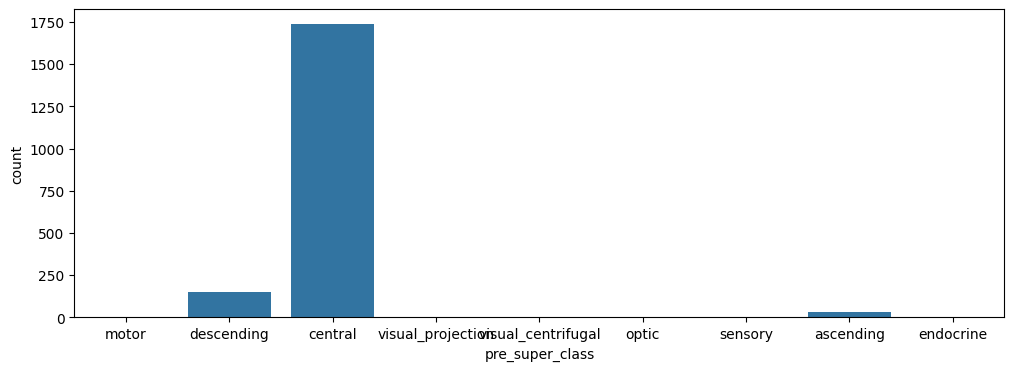

In [27]:
plt.subplots(figsize=(12, 4))
sns.countplot(post_syn_super_df, x="pre_super_class", order=unique_super_class)

<Axes: xlabel='post_super_class', ylabel='count'>

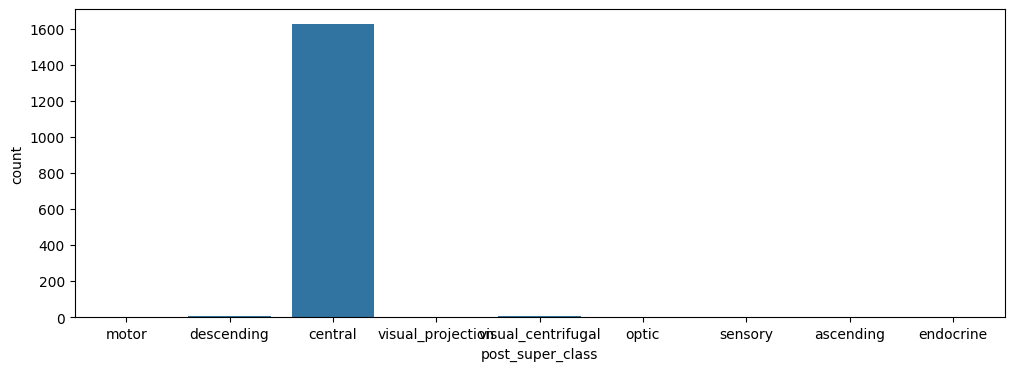

In [28]:
plt.subplots(figsize=(12, 4))
sns.countplot(pre_syn_super_df, x="post_super_class", order=unique_super_class)

# **Student task 10: Now that we have done this for super class. Can you create code blocks and generate similar plots by class, cell type and flow. Start by creating data frames or using exisiting data frames.**

# 1) Start by creating flow_annos_df, class_annos_df and cell_type_annos_df. (Remember we created these earlier)
# 2) Then create pre_flow_annos_df and post_flow_annos_df (do this carefully)
# 3) Load pre_syn and post_syn_dfs for your specific neurons.
# 4) Merge it with synapse tables
# 5) Plot

Creating a flow annotated data frame for all neurons in the data set.

In [ ]:
flow_annos_df

,id,created,valid,target_id,classification_system,cell_type,id_ref,created_ref,valid_ref,pt_supervoxel_id,pt_root_id,pt_position
0,760326,2023-09-30 05:09:51.441140+00:00,True,135,flow,efferent,135,2023-06-19 06:43:32.694340+00:00,True,78536398189730110,720575940628372613,"[462134, 314944, 202595]"
1,760327,2023-09-30 05:09:51.441140+00:00,True,131206,flow,efferent,131206,2024-01-08 19:46:33.536372+00:00,True,79097217839414238,720575940620156283,"[492890, 187909, 204117]"
2,760328,2023-09-30 05:09:51.441140+00:00,True,138571,flow,intrinsic,138571,2024-01-08 19:46:56.609400+00:00,True,81277136946061019,720575940640372277,"[620140, 99296, 158026]"
3,760329,2023-09-30 05:09:51.441140+00:00,True,137463,flow,intrinsic,137463,2024-01-08 19:46:56.002999+00:00,True,80434498856324372,720575940634601954,"[570818, 205376, 191260]"
4,760330,2023-09-30 05:09:51.441140+00:00,True,133024,flow,intrinsic,133024,2024-01-08 19:46:44.939864+00:00,True,81840568002630413,720575940624155416,"[652270, 128644, 169218]"
...,...,...,...,...,...,...,...,...,...,...,...,...
139250,397994,2023-06-19 23:22:47.293270+00:00,True,104828,flow,intrinsic,104828,2023-06-19 06:48:15.001237+00:00,True,83952592400822837,720575940626100238,"[776911, 183792, 174548]"
139251,436766,2023-06-19 23:24:21.179830+00:00,True,104809,flow,intrinsic,104809,2023-06-19 06:48:14.983796+00:00,True,84798048190170122,720575940626915216,"[824625, 246096, 194229]"
139252,402701,2023-06-19 23:23:00.124836+00:00,True,83362,flow,intrinsic,83362,2023-06-19 06:47:20.709997+00:00,True,75298954786869572,720575940645731620,"[272447, 288010, 156593]"
139253,436758,2023-06-19 23:24:21.174050+00:00,True,104819,flow,intrinsic,104819,2023-06-19 06:48:14.992064+00:00,True,84658822530652061,720575940629075755,"[815896, 335911, 204215]"


Querying pre and post syanpe tables for your root is/neuron

In [ ]:
root_id =720575940640356149
presyn_df = client.materialize.query_view("valid_synapses_nt_np_v6", filter_in_dict={"pre_pt_root_id": [root_id]})
postsyn_df = client.materialize.query_view("valid_synapses_nt_np_v6", filter_in_dict={"post_pt_root_id": [root_id]})

In [ ]:
pre_flow_annos_df = flow_annos_df[["pt_root_id", "cell_type"]].rename(
    columns={"pt_root_id": "pre_pt_root_id", "cell_type": "pre_flow"})
post_flow_annos_df = flow_annos_df[["pt_root_id", "cell_type"]].rename(
    columns={"pt_root_id": "post_pt_root_id", "cell_type": "post_flow"})

The merge step!!!

In [ ]:
post_syn_flow_df = pd.merge(postsyn_df, pre_flow_annos_df, on="pre_pt_root_id")
pre_syn_flow_df = pd.merge(presyn_df, post_flow_annos_df, on="post_pt_root_id")

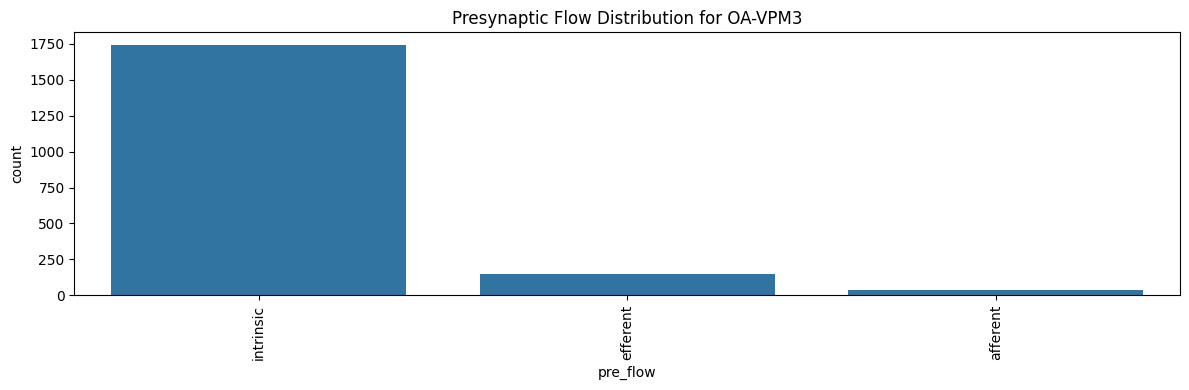

In [ ]:
plt.subplots(figsize=(12, 4))
sns.countplot(post_syn_flow_df, x="pre_flow")
plt.xticks(rotation=90)
plt.title("Presynaptic Flow Distribution for OA-VPM3")
plt.tight_layout()
plt.show()

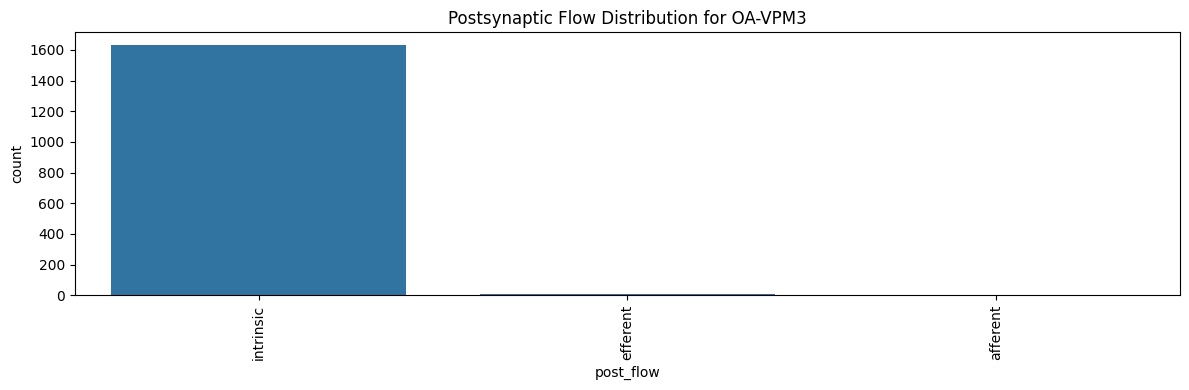

In [ ]:
plt.subplots(figsize=(12, 4))
sns.countplot(pre_syn_flow_df, x="post_flow")
plt.xticks(rotation=90)
plt.title("Postsynaptic Flow Distribution for OA-VPM3")
plt.tight_layout()
plt.show()

Bonus Student Task.

Coding with AI. Now that we understand the logic of creating data frames and mining the data in specific ways. We can also try using Gemini to do the operations above. Check what AI does for you (remember the key steps: create cell_type/flow/super class dataframes for the whole data set, create pre and post cell annotation data frames for specific root ids, load the pre and post syn data frames. Now merge the annotaation and synapse tables. The resulting data frame is ready for plotting.


Optional!!!!!!!

Extra/Bonus: Generating pre- and post- plots for multiple root ids.
Code with AI and explain each ste.